In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

from torch.utils.data import DataLoader
from models import LeNet, StoLeNet
from utils import compute_accuracy, compute_ece_loss

In [2]:
train_deterministic = True # train a deterministic model as starting point 

In [3]:

# setup device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
device

device(type='cuda')

In [4]:
# define data folder
data_dir = "./data"
fig_dir = "./figs"

In [5]:
# compose transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, transform=transform, download=False)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, transform=transform, download=False)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
# ===================================================== #
# ========= train a deterministic model =============== #
# ===================================================== #
if train_deterministic:
    num_epochs = 10
    base_model = LeNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(base_model.parameters(), lr=0.002, momentum=0.9)

    loss_list, acc_list, ece_list = [[] for _ in range(3)]
    for epoch in range(num_epochs):
        base_model.train()
        batch_loss = []
        for img, label in trainloader:
            img, label = img.to(device), label.to(device)
            pred = base_model(img)
            loss = criterion(pred, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
        avg_loss = sum(batch_loss)/len(batch_loss)
        base_acc = compute_accuracy(base_model, testloader, device=device)
        base_ece = compute_ece_loss(base_model, testloader, device=device)
        print("Base Model Epoch {} Avg Loss {:.4f} Acc {:.4f} ECE {:.4f}".format(epoch, avg_loss, base_acc, base_ece))
        loss_list.append(avg_loss)
        acc_list.append(base_acc)
        ece_list.append(base_ece)

Base Model Epoch 0 Avg Loss 1.7485 Acc 0.6496 ECE 0.0228
Base Model Epoch 1 Avg Loss 0.7392 Acc 0.7427 ECE 0.0120
Base Model Epoch 2 Avg Loss 0.6278 Acc 0.7682 ECE 0.0103
Base Model Epoch 3 Avg Loss 0.5596 Acc 0.7823 ECE 0.0162
Base Model Epoch 4 Avg Loss 0.5181 Acc 0.8093 ECE 0.0126
Base Model Epoch 5 Avg Loss 0.4784 Acc 0.8070 ECE 0.0090
Base Model Epoch 6 Avg Loss 0.4566 Acc 0.8267 ECE 0.0105
Base Model Epoch 7 Avg Loss 0.4342 Acc 0.8347 ECE 0.0148
Base Model Epoch 8 Avg Loss 0.4142 Acc 0.8324 ECE 0.0133
Base Model Epoch 9 Avg Loss 0.3969 Acc 0.8506 ECE 0.0097


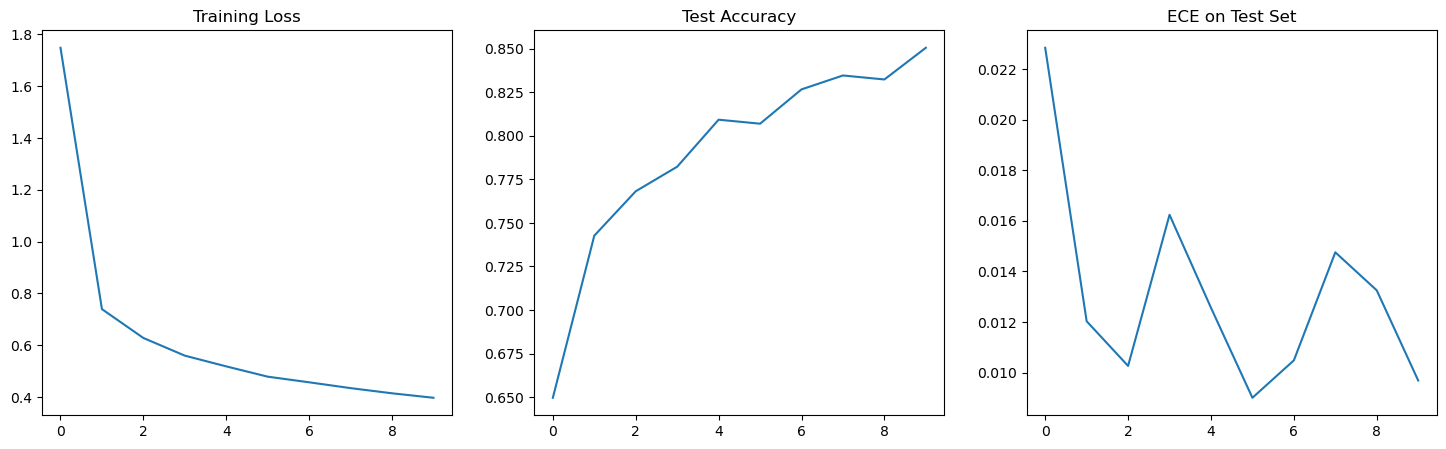

In [7]:
if train_deterministic:
    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1,3,1)
    plt.plot(loss_list)
    plt.title("Training Loss")
    plt.subplot(1,3,2)
    plt.plot(acc_list)
    plt.title("Test Accuracy")
    plt.subplot(1,3,3)
    plt.plot(ece_list)
    plt.title("ECE on Test Set")
    plt.show()
    fig.tight_layout()
    fig.savefig(fig_dir + "/" + "deterministic lenet.jpg")

In [10]:
# ===================================================== #
# =  migrate from base model, finetune and train flow = #
# ===================================================== #

# parameters for base distribution 
NormalParams = lambda scale: {"loc":1.0, "scale":scale}
# flow configurations, List of tuple (type, depth, params)
AffineLayer = [("affine", 1, {"learnable":True})]
GlowStep =  lambda depth, width:[
            ("affine", 1, {"learnable":True}), # the first stack of flows (type, depth, params)
            ("planar2d", 1, {"init_sigma":0.01}),# the second stack of flows (type, depth, params)
            ("flowstep", depth, {"width":width,"keepdim":True}),
            ("planar2d", 1, {"init_sigma":0.01})] 
Planar1d = lambda depth: [("affine", 1), 
            ("planar", depth),
            ("element", 1, {"act":"tanh"})]
# stochastic part for a layer, base distribution name, distribution parameters, flow config 
NormalAffine = ("normal", NormalParams(0.5), AffineLayer)
NormalGlowStep = ("normal", NormalParams(0.5), GlowStep(2, 10))
NormalPlanar1d = ("normal", NormalParams(0.5), Planar1d(2))
# flow config for all layers in the model  
sto_model_cfg = [NormalAffine, NormalGlowStep, NormalAffine, NormalPlanar1d, NormalAffine]

In [14]:
def train_sto_lenet(sto_model_cfg, base_model, trainloader, testloader, colored=False):
    sto_model = StoLeNet(sto_cfg=sto_model_cfg, colored=colored).to(device)

    if train_deterministic:
        sto_model.migrate_from_det_model(base_model)

    det_params, sto_params = sto_model.det_and_sto_params()
    optimizer = optim.Adam([
                    {'params': det_params, 'lr': 2e-4},
                    {'params': sto_params, 'lr': 2e-3}
                ])

    num_epochs = 30
    loss_list, ll_list, kl_list, acc_list, ece_list = [[] for _ in range(5)]
    for epoch in range(num_epochs):
        sto_model.train()
        batch_loss, batch_ll, batch_kl = [[] for _ in range(3)]
        for img, label in trainloader:
            img, label = img.to(device), label.to(device)
            pred = sto_model(img)
            log_likelihood, kl = sto_model.calc_loss(pred, label)
            loss = -log_likelihood + kl / len(trainloader.dataset)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            batch_ll.append(log_likelihood.item()) 
            batch_kl.append(kl.item()/ len(trainloader.dataset))
        avg = lambda l: sum(l)/len(l)
        avg_loss, avg_ll, avg_kl = avg(batch_loss), avg(batch_ll), avg(batch_kl)
        sto_acc = compute_accuracy(sto_model, testloader)
        sto_ece = compute_ece_loss(sto_model, testloader)
        print("Sto Model Epoch {} Avg Loss {:.4f} Likelihood {:.4f} KL {:.4f} Acc {:.4f} ECE {:.4f}".format(
                            epoch, avg_loss, avg_ll, avg_kl,sto_acc, sto_ece))
        loss_list.append(avg_loss)
        ll_list.append(avg_ll)
        kl_list.append(avg_kl)
        acc_list.append(sto_acc)
        ece_list.append(sto_ece)

    return sto_model, loss_list, ll_list, kl_list, acc_list, ece_list

In [9]:
results = train_sto_lenet(sto_model_cfg, base_model, trainloader, testloader)

Sto Model Epoch 0 Avg Loss 0.7181 Likelihood -0.7157 KL 0.0024 Acc 0.8292 ECE 0.0628
Sto Model Epoch 1 Avg Loss 0.5174 Likelihood -0.5139 KL 0.0035 Acc 0.8431 ECE 0.0357
Sto Model Epoch 2 Avg Loss 0.4600 Likelihood -0.4556 KL 0.0044 Acc 0.8549 ECE 0.0446
Sto Model Epoch 3 Avg Loss 0.4221 Likelihood -0.4170 KL 0.0051 Acc 0.8637 ECE 0.0359
Sto Model Epoch 4 Avg Loss 0.3964 Likelihood -0.3906 KL 0.0058 Acc 0.8627 ECE 0.0227
Sto Model Epoch 5 Avg Loss 0.3748 Likelihood -0.3684 KL 0.0064 Acc 0.8689 ECE 0.0272
Sto Model Epoch 6 Avg Loss 0.3559 Likelihood -0.3491 KL 0.0068 Acc 0.8747 ECE 0.0219
Sto Model Epoch 7 Avg Loss 0.3383 Likelihood -0.3312 KL 0.0072 Acc 0.8774 ECE 0.0069
Sto Model Epoch 8 Avg Loss 0.3251 Likelihood -0.3176 KL 0.0075 Acc 0.8803 ECE 0.0089
Sto Model Epoch 9 Avg Loss 0.3155 Likelihood -0.3078 KL 0.0078 Acc 0.8834 ECE 0.0059
Sto Model Epoch 10 Avg Loss 0.3057 Likelihood -0.2977 KL 0.0080 Acc 0.8826 ECE 0.0110
Sto Model Epoch 11 Avg Loss 0.2954 Likelihood -0.2871 KL 0.0083 

In [20]:
def plot_results(results, anno=""):
    sto_model, loss_list, ll_list, kl_list, acc_list, ece_list = results 
    fig = plt.figure(figsize=(15, 10))
    plt.subplot(2,3,1)
    plt.plot(loss_list)
    plt.title("Negative ELBO")
    plt.subplot(2,3,2)
    plt.plot(ll_list)
    plt.title("Log Likelihood")
    plt.subplot(2,3,3)
    plt.plot(kl_list)
    plt.title("KL Divergence")
    plt.subplot(2,3,4)
    plt.plot(acc_list)
    plt.title("Test Accuracy")
    plt.subplot(2,3,5)
    plt.plot(ece_list)
    plt.title("ECE on testset")
    plt.show()
    fig.tight_layout()
    fig.savefig(fig_dir + "/" + "stochastic_lenet_{}.jpg".format(anno))

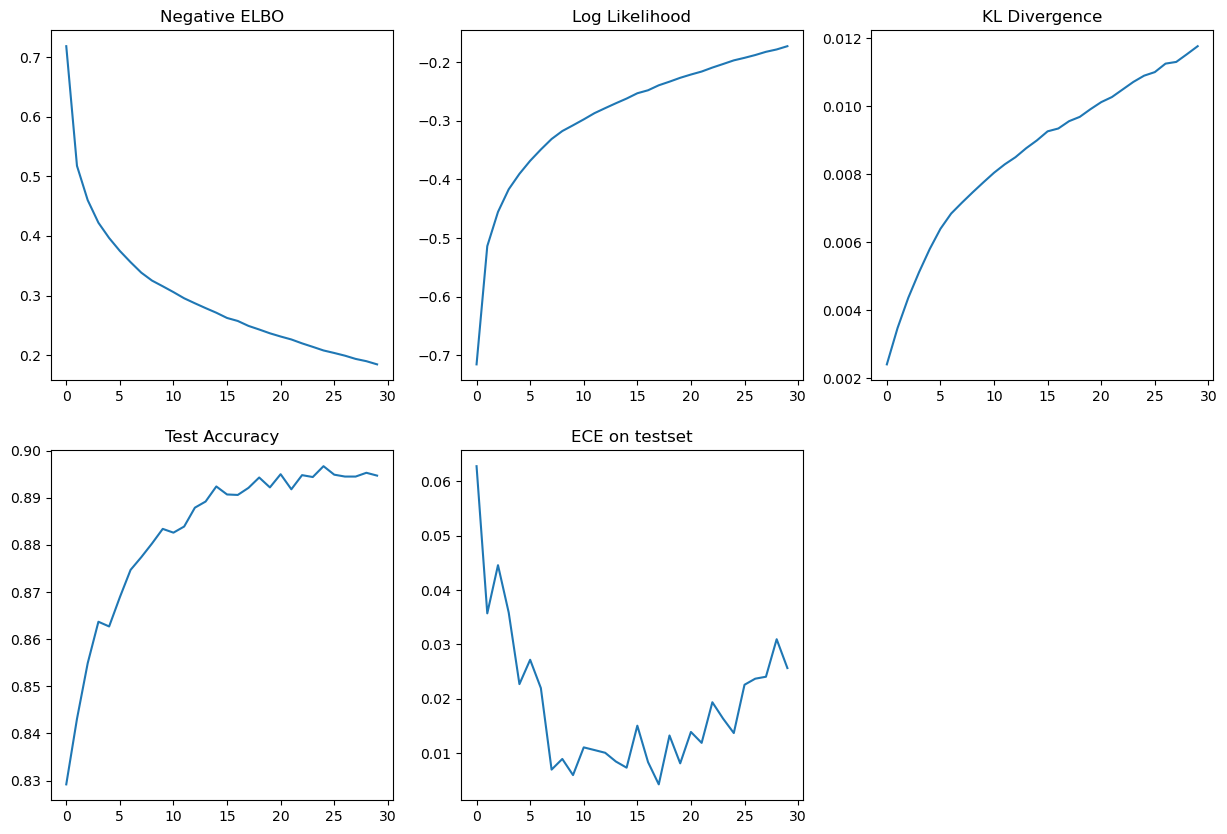

In [10]:
plot_results(results, anno="flow")

better results compared to last week (without the "step of flow" in Glow paper)

last time the ECE goes higher as training goes on, this time it's lower than the deterministic LeNet

should probably take the check point arount epoch 10~15, the model seems to overfit after about 20 epochs 

the accuracy increases (84% => 89%): model capacity has been increased by the stochastic part (some has a flow, others don't)

ece is slightly lower (0.01 => 0.004): model is better calibrated, so the flow helps 

if we remove all flows (only keep the base gaussian distribution together with an affine transformation)

the results is almost as good as the complicated model with flow. 

probably the best balanced results are (Acc 0.8903 ECE 0.0051), compared to the one with flow (0.8921 ECE 0.0042)

In [11]:
sto_model_cfg = [NormalAffine, NormalAffine, NormalAffine, NormalAffine, NormalAffine]
results = train_sto_lenet(sto_model_cfg, base_model, trainloader, testloader)

Sto Model Epoch 0 Avg Loss 0.8318 Likelihood -0.8315 KL 0.0002 Acc 0.8132 ECE 0.1027
Sto Model Epoch 1 Avg Loss 0.6012 Likelihood -0.6004 KL 0.0008 Acc 0.8248 ECE 0.0594
Sto Model Epoch 2 Avg Loss 0.5312 Likelihood -0.5299 KL 0.0013 Acc 0.8411 ECE 0.0606
Sto Model Epoch 3 Avg Loss 0.4797 Likelihood -0.4780 KL 0.0017 Acc 0.8494 ECE 0.0563
Sto Model Epoch 4 Avg Loss 0.4487 Likelihood -0.4466 KL 0.0021 Acc 0.8531 ECE 0.0424
Sto Model Epoch 5 Avg Loss 0.4180 Likelihood -0.4156 KL 0.0024 Acc 0.8599 ECE 0.0294
Sto Model Epoch 6 Avg Loss 0.3962 Likelihood -0.3934 KL 0.0027 Acc 0.8650 ECE 0.0254
Sto Model Epoch 7 Avg Loss 0.3765 Likelihood -0.3735 KL 0.0030 Acc 0.8697 ECE 0.0331
Sto Model Epoch 8 Avg Loss 0.3636 Likelihood -0.3604 KL 0.0032 Acc 0.8736 ECE 0.0261
Sto Model Epoch 9 Avg Loss 0.3486 Likelihood -0.3451 KL 0.0035 Acc 0.8746 ECE 0.0231
Sto Model Epoch 10 Avg Loss 0.3338 Likelihood -0.3302 KL 0.0037 Acc 0.8752 ECE 0.0156
Sto Model Epoch 11 Avg Loss 0.3239 Likelihood -0.3201 KL 0.0039 

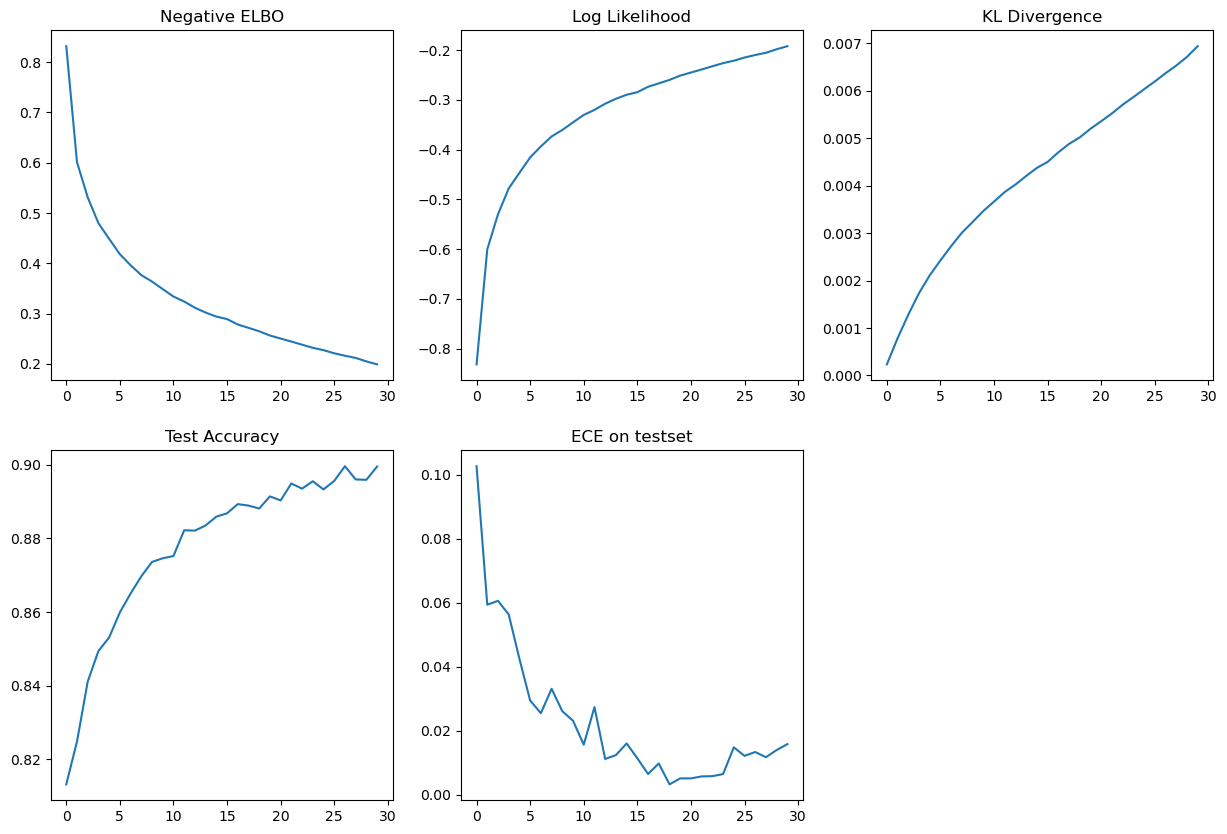

In [12]:
plot_results(results, anno="no_flow")

## Redo on CIFAR 10

In [5]:
# transforms adopted from https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
if train_deterministic:
    num_epochs = 20
    base_model = LeNet(colored=True).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(base_model.parameters(), lr=0.002, momentum=0.9)

    loss_list, acc_list, ece_list = [[] for _ in range(3)]
    for epoch in range(num_epochs):
        base_model.train()
        batch_loss = []
        for img, label in trainloader:
            img, label = img.to(device), label.to(device)
            pred = base_model(img)
            loss = criterion(pred, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
        avg_loss = sum(batch_loss)/len(batch_loss)
        base_acc = compute_accuracy(base_model, testloader, device=device)
        base_ece = compute_ece_loss(base_model, testloader, device=device)
        print("Base Model Epoch {} Avg Loss {:.4f} Acc {:.4f} ECE {:.4f}".format(epoch, avg_loss, base_acc, base_ece))
        loss_list.append(avg_loss)
        acc_list.append(base_acc)
        ece_list.append(base_ece)

Base Model Epoch 0 Avg Loss 2.2746 Acc 0.2361 ECE 0.0744
Base Model Epoch 1 Avg Loss 1.9967 Acc 0.3249 ECE 0.0504
Base Model Epoch 2 Avg Loss 1.8312 Acc 0.3559 ECE 0.0189
Base Model Epoch 3 Avg Loss 1.7180 Acc 0.4105 ECE 0.0547
Base Model Epoch 4 Avg Loss 1.6540 Acc 0.4277 ECE 0.0403
Base Model Epoch 5 Avg Loss 1.6069 Acc 0.4557 ECE 0.0491
Base Model Epoch 6 Avg Loss 1.5666 Acc 0.4589 ECE 0.0274
Base Model Epoch 7 Avg Loss 1.5343 Acc 0.4749 ECE 0.0436
Base Model Epoch 8 Avg Loss 1.4995 Acc 0.4897 ECE 0.0406
Base Model Epoch 9 Avg Loss 1.4690 Acc 0.5129 ECE 0.0419
Base Model Epoch 10 Avg Loss 1.4430 Acc 0.5132 ECE 0.0197
Base Model Epoch 11 Avg Loss 1.4102 Acc 0.5272 ECE 0.0218
Base Model Epoch 12 Avg Loss 1.3913 Acc 0.5392 ECE 0.0409
Base Model Epoch 13 Avg Loss 1.3720 Acc 0.5430 ECE 0.0381
Base Model Epoch 14 Avg Loss 1.3430 Acc 0.5538 ECE 0.0460
Base Model Epoch 15 Avg Loss 1.3298 Acc 0.5490 ECE 0.0081
Base Model Epoch 16 Avg Loss 1.3065 Acc 0.5655 ECE 0.0345
Base Model Epoch 17 Avg 

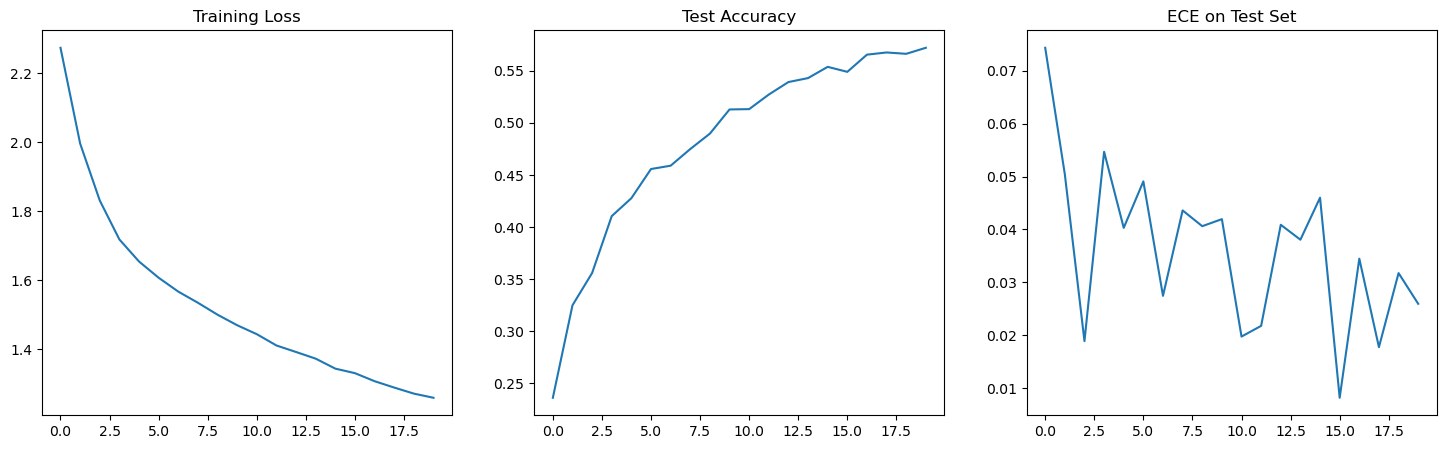

In [8]:
if train_deterministic:
    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1,3,1)
    plt.plot(loss_list)
    plt.title("Training Loss")
    plt.subplot(1,3,2)
    plt.plot(acc_list)
    plt.title("Test Accuracy")
    plt.subplot(1,3,3)
    plt.plot(ece_list)
    plt.title("ECE on Test Set")
    plt.show()
    fig.tight_layout()
    fig.savefig(fig_dir + "/" + "deterministic lenet.jpg")

In [15]:
sto_model_cfg = [NormalAffine, NormalGlowStep, NormalAffine, NormalPlanar1d, NormalAffine]
results = train_sto_lenet(sto_model_cfg, base_model, trainloader, testloader, colored=True)

Sto Model Epoch 0 Avg Loss 1.6638 Likelihood -1.6615 KL 0.0024 Acc 0.5476 ECE 0.1077
Sto Model Epoch 1 Avg Loss 1.4849 Likelihood -1.4818 KL 0.0031 Acc 0.5565 ECE 0.0945
Sto Model Epoch 2 Avg Loss 1.4238 Likelihood -1.4199 KL 0.0039 Acc 0.5727 ECE 0.0957
Sto Model Epoch 3 Avg Loss 1.3798 Likelihood -1.3752 KL 0.0045 Acc 0.5699 ECE 0.0901
Sto Model Epoch 4 Avg Loss 1.3503 Likelihood -1.3452 KL 0.0052 Acc 0.5876 ECE 0.0923
Sto Model Epoch 5 Avg Loss 1.3228 Likelihood -1.3170 KL 0.0057 Acc 0.5955 ECE 0.0759
Sto Model Epoch 6 Avg Loss 1.3030 Likelihood -1.2968 KL 0.0062 Acc 0.6048 ECE 0.0870
Sto Model Epoch 7 Avg Loss 1.2771 Likelihood -1.2704 KL 0.0067 Acc 0.5959 ECE 0.0592
Sto Model Epoch 8 Avg Loss 1.2593 Likelihood -1.2521 KL 0.0071 Acc 0.6038 ECE 0.0673
Sto Model Epoch 9 Avg Loss 1.2428 Likelihood -1.2352 KL 0.0076 Acc 0.6077 ECE 0.0568
Sto Model Epoch 10 Avg Loss 1.2264 Likelihood -1.2184 KL 0.0080 Acc 0.6078 ECE 0.0399
Sto Model Epoch 11 Avg Loss 1.2122 Likelihood -1.2039 KL 0.0084 

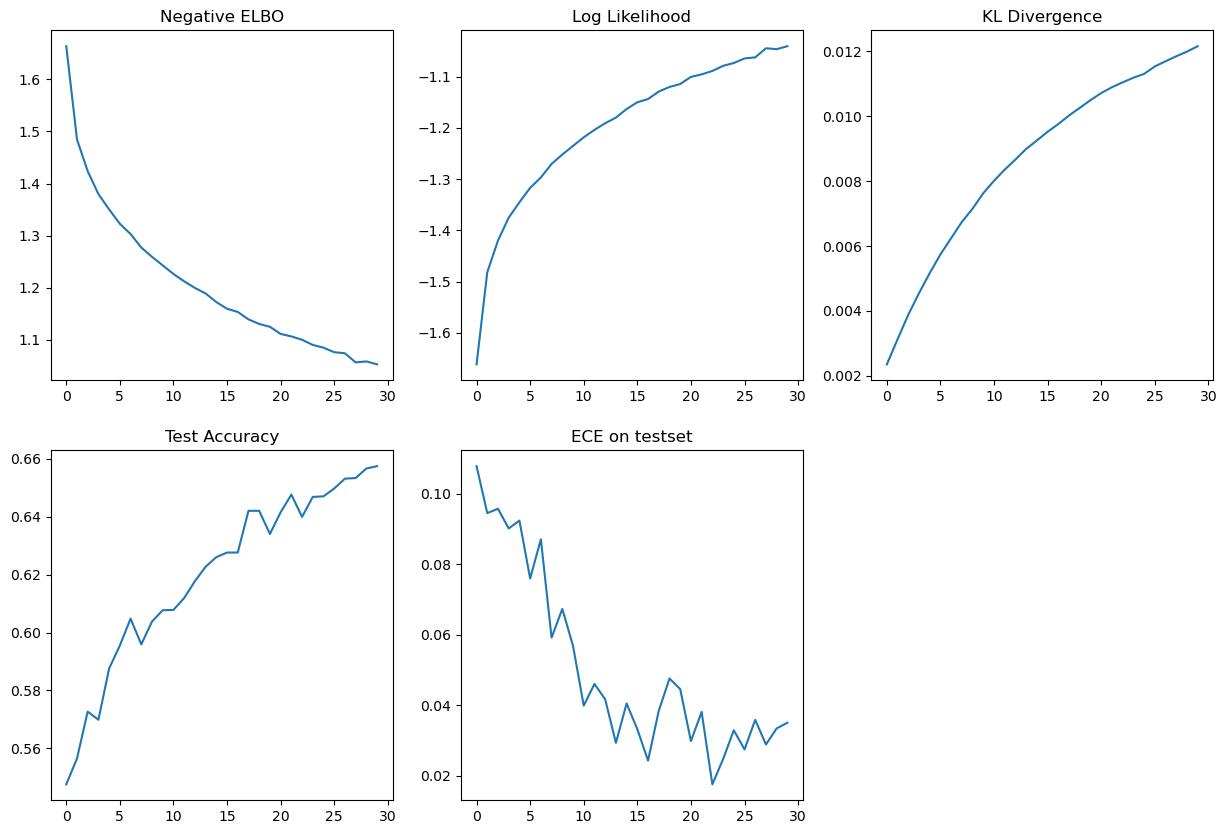

In [21]:
plot_results(results, anno="flow_CIFAR10")

In [22]:
sto_model_cfg = [NormalAffine, NormalAffine, NormalAffine, NormalAffine, NormalAffine]
results = train_sto_lenet(sto_model_cfg, base_model, trainloader, testloader, colored=True)

Sto Model Epoch 0 Avg Loss 1.6923 Likelihood -1.6922 KL 0.0001 Acc 0.5506 ECE 0.1668
Sto Model Epoch 1 Avg Loss 1.5626 Likelihood -1.5623 KL 0.0003 Acc 0.5489 ECE 0.1164
Sto Model Epoch 2 Avg Loss 1.5046 Likelihood -1.5041 KL 0.0005 Acc 0.5589 ECE 0.1122
Sto Model Epoch 3 Avg Loss 1.4657 Likelihood -1.4649 KL 0.0008 Acc 0.5655 ECE 0.1215
Sto Model Epoch 4 Avg Loss 1.4185 Likelihood -1.4174 KL 0.0011 Acc 0.5754 ECE 0.1014
Sto Model Epoch 5 Avg Loss 1.3972 Likelihood -1.3959 KL 0.0013 Acc 0.5789 ECE 0.1028
Sto Model Epoch 6 Avg Loss 1.3711 Likelihood -1.3694 KL 0.0016 Acc 0.5854 ECE 0.0854
Sto Model Epoch 7 Avg Loss 1.3442 Likelihood -1.3423 KL 0.0019 Acc 0.5911 ECE 0.0918
Sto Model Epoch 8 Avg Loss 1.3242 Likelihood -1.3220 KL 0.0022 Acc 0.5947 ECE 0.0861
Sto Model Epoch 9 Avg Loss 1.2993 Likelihood -1.2968 KL 0.0025 Acc 0.5989 ECE 0.0769
Sto Model Epoch 10 Avg Loss 1.2865 Likelihood -1.2838 KL 0.0027 Acc 0.6055 ECE 0.0665
Sto Model Epoch 11 Avg Loss 1.2680 Likelihood -1.2651 KL 0.0030 

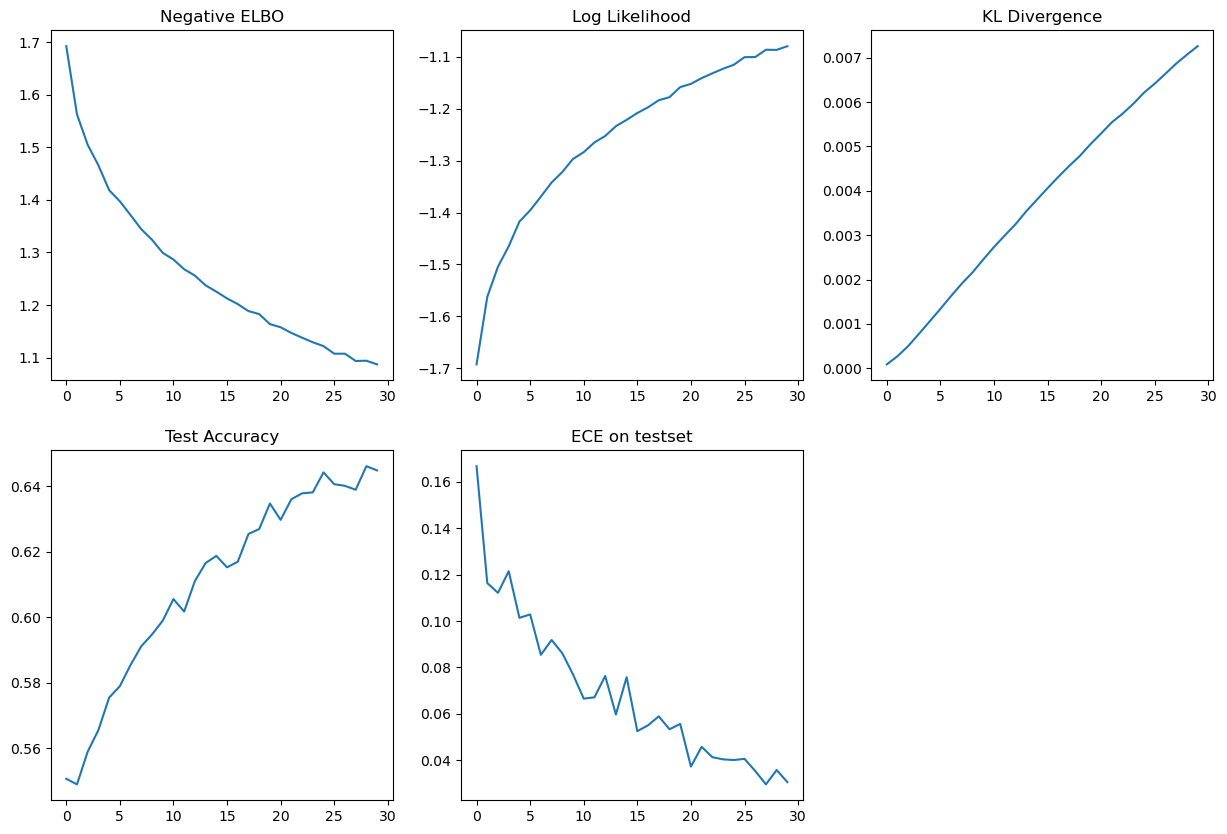

In [23]:
plot_results(results, anno="no_flow_CIFAR10")


In [ ]:
result_list = 